In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import pickle


In [9]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model,Sequential,load_model
from keras.layers import *

In [10]:
import re
import json
import collections
import time
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences


In [11]:
from keras.preprocessing import image

In [12]:
def readtextfile(path):
    
    with open(path,encoding='utf8') as f:
        text = f.read()
    return text

In [13]:
text = readtextfile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")

In [14]:
captions = text.split('\n')[:-1] #last line is empty


In [15]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [16]:
cap = captions[0].split('\t')
img_id = cap[0].split('.')[0]
caption = cap[1]

In [17]:

def get_img_id_to_caption_mapping(textfile):
    description = {}
    for ix in range(len(captions)):
        tex = captions[ix].split('\t')
       
        img_id = tex[0].split('.')[0]
        
        cap = tex[1]
        
        if description.get(img_id) is None:
            description[img_id] = []
        description[img_id].append(cap)
        
    return description

In [18]:
descriptions = get_img_id_to_caption_mapping(captions)

In [19]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

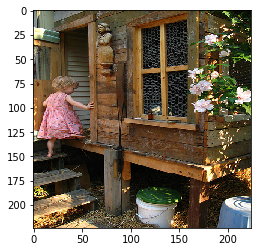

In [20]:
#verify that the image id has been mapped with correct image
IMG_path = "./Flickr_Data/Flickr_Data/Images/"
img = image.load_img(IMG_path+"1000268201_693b08cb0e.jpg",target_size=(224,224,3))
img = image.img_to_array(img)/255.
plt.imshow(img)

In [21]:
def clean_captions(sentence):\
    
    """
    this function takes a sentence, converts to lower case and remove any special character,
    number if any present, and removes any word if the len of the word is less than 2.
    
    """
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = [x for x in sentence.split() if len(x)>1]
    sentence = " ".join(sentence)
    return sentence
    
    
    

In [22]:
#cleaning caption on every caption in description

for img_id,caption_list in descriptions.items():
    
    for i in range(len(caption_list)):
        
        caption_list[i] = clean_captions(caption_list[i])

In [23]:
descriptions['1000268201_693b08cb0e'] #words like "A" have been removed and sentence has been converted to lower case.

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [24]:
#saving descriptions mapping to a text file for future purposes

with open("description.txt",'w',encoding='utf8') as f:
    f.write(str(descriptions))

In [25]:
description = None
with open("description.txt",'r') as f:
    description = f.read()
    
json_acceptable_string = description.replace("'","\"")
description = json.loads(json_acceptable_string)

In [26]:
#making a vocab out of all captions

vocab = set()
total_words = []

for key in description.keys():
    [vocab.update(sentence.split()) for sentence in description[key]]
    [total_words.append(i) for des in description[key] for i in des.split()]

In [27]:
print(len(total_words),len(vocab))

373837 8424


In [28]:
#the size of vocab is quite large in comparison to total words, so setting a threshold against which 
#presence of word in vocab is decieded, and freq of the words shall be choosed.
#using collections module

counter = collections.Counter(total_words)
freq_count = dict(counter)

In [29]:
print(freq_count['the']) # mapping of the word against is occurences


18420


In [30]:
sorted_freq_cnt = sorted(freq_count.items(),reverse=True,key = lambda x:x[1])
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [31]:
len(total_words) #this will be the final lenght of vocab
#we decreased the size of vocab from 8424 to 1845

1845

In [32]:
#opening file containing all the image ids.
train = readtextfile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test = readtextfile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [33]:
train = [row.split('.')[0] for row in train.split('\n')]


In [34]:
test = [row.split('.')[0] for row in test.split('\n')]

In [35]:
print(len(description.keys()),len(train),len(test))


8092 6001 1001


In [36]:
train = train[:-1] #run only once
test = test[:-1] #last elements were empty strings

In [37]:
# adding a start token "startseq" and end token "endseq" at the starting and ending of each caption respectively.
train_description = {}
for img_id in train:
    
    train_description[img_id] = []
    
    for caption in description[img_id]:
        caption = "startseq " + caption + " endseq"
        
        train_description[img_id].append(caption)

In [38]:
train_description['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [39]:
#generating image feature vectors using transfer learning
#using ResNet50 as model
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [40]:
model.layers[-2]

In [41]:
model_new = Model(model.input,model.layers[-2].output)

In [44]:
def preprocess_image(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)  #normalization function for ResNet50 model
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


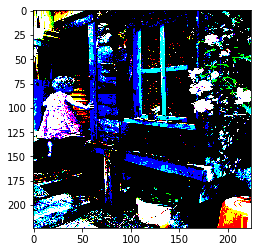

In [45]:
plt.imshow(preprocess_image(IMG_path+"1000268201_693b08cb0e.jpg")[0])
plt.show()
#how a image looks after perprocessing

In [46]:
def encode_img(img):
    """takes a path to image file, process it, and return a feature vector of shape
    (2048,)"""
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((2048,))
    return feature_vector

In [47]:
encode_img(IMG_path+"1000268201_693b08cb0e.jpg").shape

(2048,)

In [48]:
start = time.time()
encoding_train = {}

for i,img_id in enumerate(train):
    
    img_path = IMG_path+img_id+".jpg"
    encoding_train[img_id] = encode_img(img_path)
    if i%100==0: 
        print(i)
    
end = time.time()
print(end-start)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
1304.5154242515564


In [49]:
start = time.time()
encoding_test = {}

for i,img_id in enumerate(test):
    
    img_path = IMG_path+img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path)
    if i%100==0: 
        print(i)
    
end = time.time()
print(end-start)

0
100
200
300
400
500
600
700
800
900
143.38782286643982


In [50]:
!mkdir saved

A subdirectory or file saved already exists.


In [54]:
with open("saved/encoded_train_features.pkl",'wb') as f:
    pickle.dump(encoding_train,f)
with open("saved/encoded_test_features.pkl",'wb') as f:
    pickle.dump(encoding_test,f)

# Data processing for Captions

In [55]:
word_to_idx = {}
idx_to_word = {}

for idx,word in enumerate(total_words):
    #we dont any word to have idx as 0.
    word_to_idx[word] = idx + 1
    idx_to_word[idx+1] = word

In [56]:
print(len(idx_to_word))

1845


In [57]:
# adding our start and end tokens "startseq" and "endseq" in our mapping
word_to_idx['startseq']= 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [59]:
vocab_size = len(word_to_idx)+1
print(vocab_size)

1848


In [60]:
max_len = 0
for key in train_description.keys():
    
     for cap in train_description[key]:
            max_len = max(max_len,len(cap.split()))

In [61]:
max_len #maximum possible lenght of lenght in dataset

35

In [148]:
def data_generator(encoding_train,train_description,max_len,batch_size,word_to_idx):
    
    X1 = [] #will contain feature of images
    X2 = [] # will contain captions in sequential form
    Y = [] # will contain words succeding corresponding sequence in X2
    n=0
    while True:
        
        for keys,desc_list in train_description.items():
            n+=1
            img = encoding_train[key]
        
            for desc in desc_list:
            
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
            
                for i in range(1,len(seq)):
                
                    xi = seq[0:i]
                    yi = seq[i]
                
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                        
                
                    X1.append(img)
                    X2.append(xi)
                    Y.append(yi)
                
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(Y)]
                
                    X1,X2,Y = [],[],[]
                    n=0
         
            
        

data_generator(encoding_train=encoding_train,train_description=train_description,).next()


In [150]:
a = data_generator(encoding_train=encoding_train,train_description=train_description,max_len=max_len,batch_size=4,word_to_idx=word_to_idx)

In [164]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    
                    
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [165]:
a = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size=1)

In [173]:
x = next(a)

In [174]:
x

[[array([[0.6499896 , 0.45327288, 0.35990578, ..., 0.01184077, 0.17420338,
          0.04910814],
         [0.6499896 , 0.45327288, 0.35990578, ..., 0.01184077, 0.17420338,
          0.04910814],
         [0.6499896 , 0.45327288, 0.35990578, ..., 0.01184077, 0.17420338,
          0.04910814],
         ...,
         [0.59114224, 0.2431549 , 0.        , ..., 1.1071402 , 0.44211778,
          0.41112942],
         [0.59114224, 0.2431549 , 0.        , ..., 1.1071402 , 0.44211778,
          0.41112942],
         [0.59114224, 0.2431549 , 0.        , ..., 1.1071402 , 0.44211778,
          0.41112942]], dtype=float32),
  array([[1846,    0,    0, ...,    0,    0,    0],
         [1846,   24,    0, ...,    0,    0,    0],
         [1846,   24,    6, ...,    0,    0,    0],
         ...,
         [1846,   24,    6, ...,    0,    0,    0],
         [1846,   24,    6, ...,    0,    0,    0],
         [1846,   24,    6, ...,    0,    0,    0]])],
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 

# embedding


In [77]:
f= open("glove.6B.50d.txt",'r',encoding='utf8') 
    

In [78]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    vector = np.array(values[1:],dtype='float32')
    
    embedding_index[word] = vector

In [79]:
f.close()

In [80]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    
    for word,idx in word_to_idx.items():
        vector = embedding_index.get(word)
        
        if vector is not None:
            matrix[idx] = vector
            
    return matrix

In [81]:
embedding_matrix = get_embedding_matrix()

In [82]:
embedding_matrix.shape

(1848, 50)

In [83]:
#model architecture

In [227]:
input_img_feat_vec = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_feat_vec)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [228]:
#caption feature vectors
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [229]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)


model  = Model(inputs=[input_img_feat_vec,input_captions],outputs=outputs)


In [230]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [231]:
model.layers[2].set_weights([embedding_matrix])

In [232]:
model.layers[2].trainable = False

In [244]:
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['acc'])


In [242]:
#model training
epochs = 10
batch_size = 6
steps = len(train_description)//batch_size

In [235]:
generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)


In [245]:
def train():
    #generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
    for i in range(epochs):
       
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        if i%2==0:
            model.save("./model_weights/model_new_final"+str(i*2)+'.h5')

In [243]:
from keras.optimizers import Adam
adam = Adam(lr=0.0001)

In [246]:
train()

Epoch 1/1
1000/1000 [==============================] - 333s 333ms/step - loss: 2.7502 - acc: 0.3567
Epoch 1/1
1000/1000 [==============================] - 272s 272ms/step - loss: 2.6023 - acc: 0.3775
Epoch 1/1
1000/1000 [==============================] - 285s 285ms/step - loss: 2.6524 - acc: 0.3692
Epoch 1/1
1000/1000 [==============================] - 270s 270ms/step - loss: 2.5724 - acc: 0.3810
Epoch 1/1
1000/1000 [==============================] - 247s 247ms/step - loss: 2.6196 - acc: 0.3727
Epoch 1/1
1000/1000 [==============================] - 275s 275ms/step - loss: 2.5611 - acc: 0.3833
Epoch 1/1
1000/1000 [==============================] - 274s 274ms/step - loss: 2.5975 - acc: 0.3772
Epoch 1/1
1000/1000 [==============================] - 275s 275ms/step - loss: 2.5433 - acc: 0.3847
Epoch 1/1
1000/1000 [==============================] - 276s 276ms/step - loss: 2.5803 - acc: 0.3780
Epoch 1/1
1000/1000 [==============================] - 273s 273ms/step - loss: 2.5296 - acc: 0.3872


In [130]:
!mkdir model_weights

In [203]:
model.load_weights('./model_weights/model_new2.h5')

In [251]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

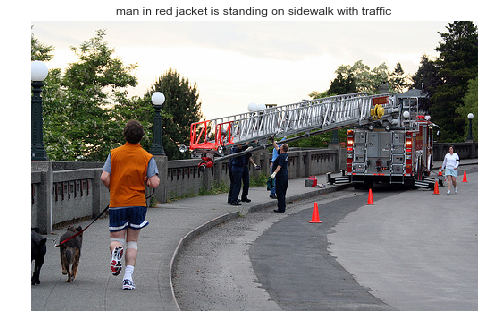

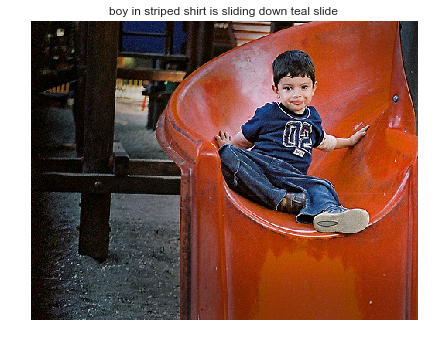

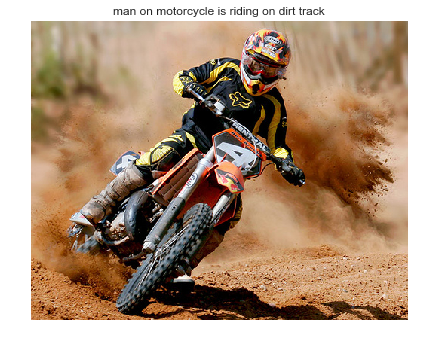

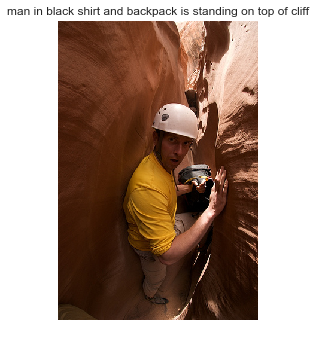

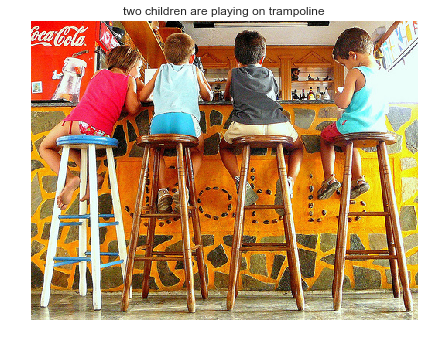

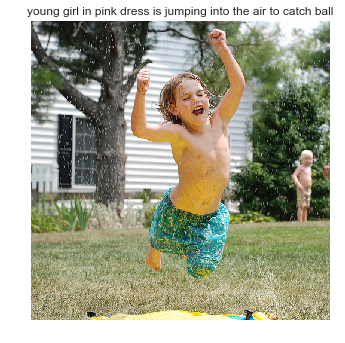

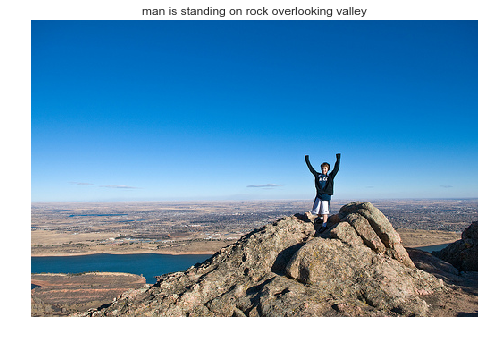

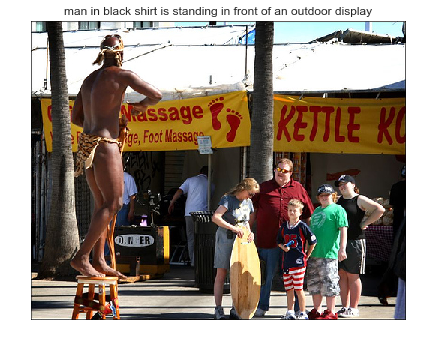

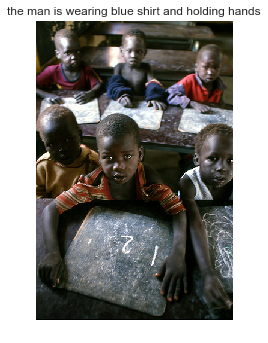

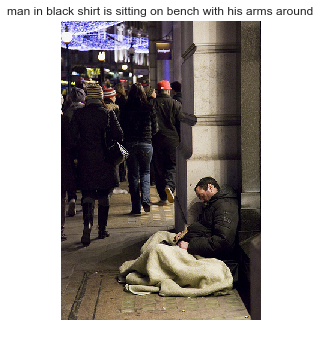

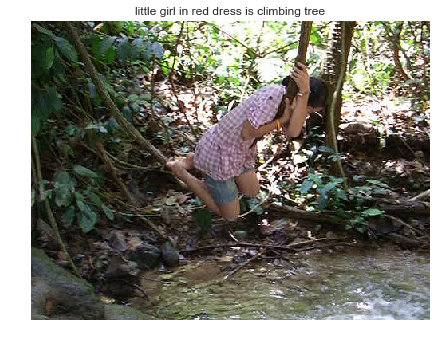

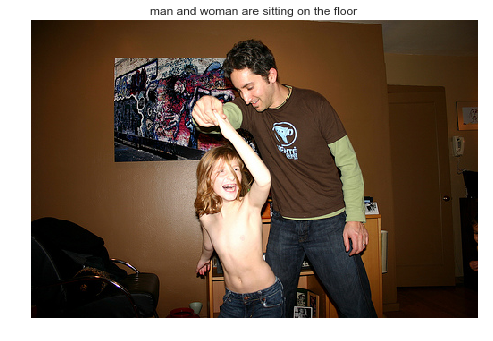

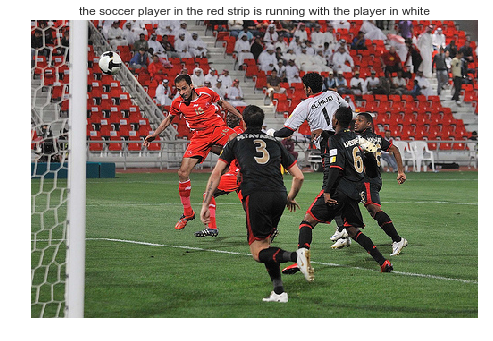

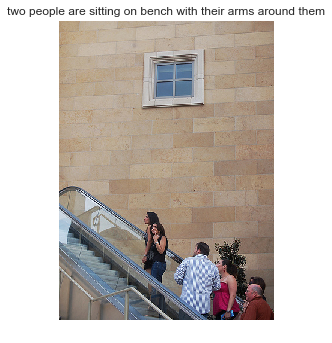

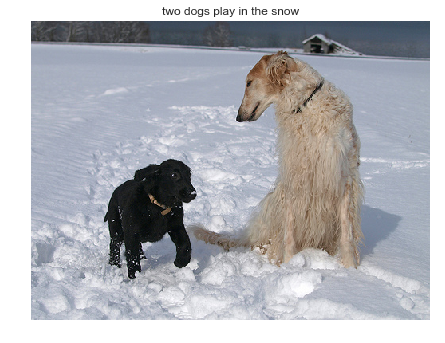

In [259]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
  
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    y = plt.imread(IMG_path+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
   # print(caption)
    
    plt.title(caption)
    plt.imshow(y)
    plt.axis("off")
    plt.savefig("image_captioned_"+str(i*3)+'.jpg')
 

    plt.show()
    

In [254]:
plt.style.use('seaborn')

In [256]:
model_pred = load_model("./model_weights/model_9.h5")

In [212]:
x = list(encoding_train.keys())

In [213]:
x[20]

'2187222896_c206d63396'

In [214]:
predict_caption

<function __main__.predict_caption(photo)>

In [215]:
img = encoding_train[x[20]]

In [216]:
img = img.reshape((1,-1))

In [217]:
img.shape

(1, 2048)

In [218]:
predict_caption(img)


'man in red shirt and black pants is standing on the beach'

In [265]:
img.shape

(1, 2048)

In [270]:
model_pred.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [222]:
generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)

for i in range(5):
   # generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
    
    print(next(generator))
       

[[array([[0.28047323, 0.40687436, 0.08379986, ..., 0.910792  , 0.04341814,
        0.09577893],
       [0.28047323, 0.40687436, 0.08379986, ..., 0.910792  , 0.04341814,
        0.09577893],
       [0.28047323, 0.40687436, 0.08379986, ..., 0.910792  , 0.04341814,
        0.09577893],
       ...,
       [0.6499896 , 0.45327288, 0.35990578, ..., 0.01184077, 0.17420338,
        0.04910814],
       [0.6499896 , 0.45327288, 0.35990578, ..., 0.01184077, 0.17420338,
        0.04910814],
       [0.6499896 , 0.45327288, 0.35990578, ..., 0.01184077, 0.17420338,
        0.04910814]], dtype=float32), array([[1846,    0,    0, ...,    0,    0,    0],
       [1846,   12,    0, ...,    0,    0,    0],
       [1846,   12,    6, ...,    0,    0,    0],
       ...,
       [1846,   24,    6, ...,    0,    0,    0],
       [1846,   24,    6, ...,    0,    0,    0],
       [1846,   24,    6, ...,    0,    0,    0]])], array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0.

In [258]:
model.save('./model_weights/model_final_trained_20epochs.h5')